# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch10/ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-11-13 02:51:34--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-11-13 02:51:34 (23.7 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] numpy 1.23.5
[OK] scipy 1.11.3
[OK] matplotlib 3.7.1
[OK] sklearn 1.2.2
[OK] pandas 1.5.3


# 10장 - 레이블되지 않은 데이터 다루기: 군집 분석

### 목차

- k-평균 알고리즘을 사용하여 유사한 객체 그룹핑
    - 사이킷런을 사용한 k-평균 군집
    - k-평균 ++로 초기 클러스터 센트로이드를 똑똑하게 할당
    - 직접 군집 vs 간접 군집
    - 엘보우 방법을 사용하여 최적의 클러스터 개수 찾기
    - 실루엣 그래프로 군집 품질을 정량화
- 계층적인 트리로 클러스터 조직화
    - 상향식으로 클러스터 묶기
    - 거리 행렬에서 계층 군집 수행
    - 히트맵에 덴드로그램 연결
    - 사이킷런에서 병합 군집 적용
- DBSCAN을 사용하여 밀집도가 높은 지역 찾기
- 요약

In [3]:
from IPython.display import Image

# k-평균 알고리즘을 사용하여 유사한 객체 그룹핑

## 사이킷런을 사용한 k-평균 군집

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

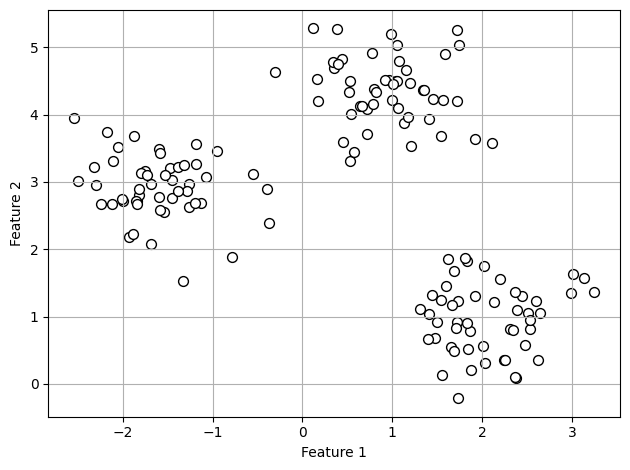

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1],
            c='white', marker='o', edgecolor='black', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.tight_layout()
# plt.savefig('images/11_01.png', dpi=300)
plt.show()

In [6]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

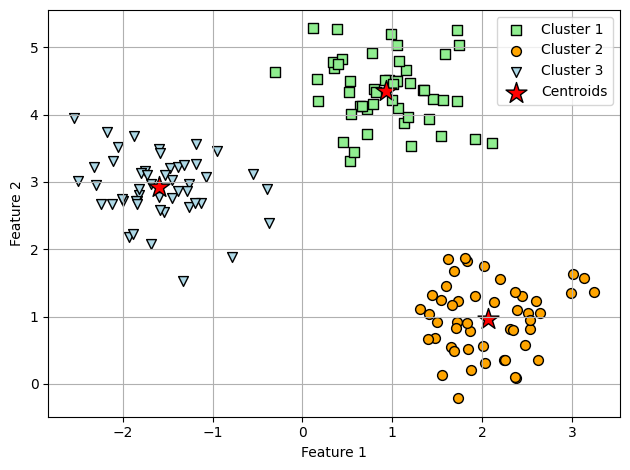

In [7]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
# plt.savefig('images/11_02.png', dpi=300)
plt.show()

## k-평균 ++로 초기 클러스터 센트로이드를 똑똑하게 할당

## 직접 군집 vs 간접 군집

## 엘보우 방법을 사용하여 최적의 클러스터 개수 찾기

In [8]:
print(f'왜곡: {km.inertia_:.2f}')

왜곡: 72.48


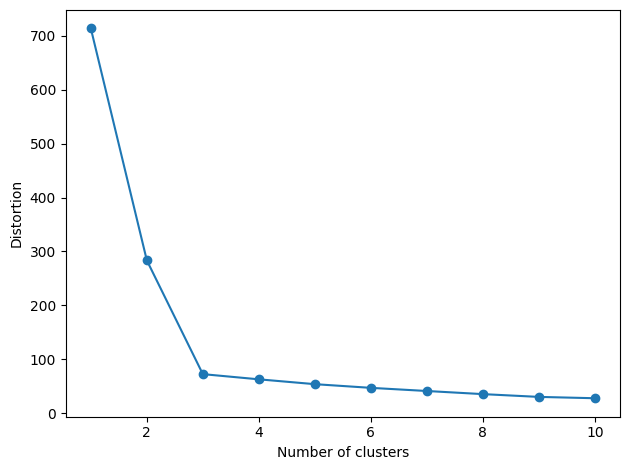

In [9]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
# plt.savefig('images/11_03.png', dpi=300)
plt.show()

## 실루엣 그래프로 군집 품질을 정량화

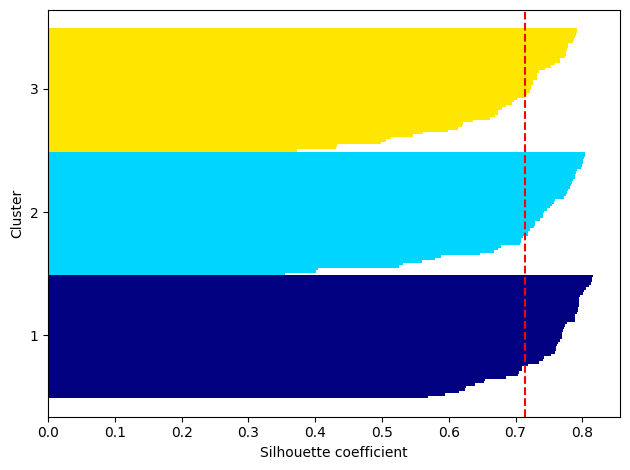

In [10]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('images/11_04.png', dpi=300)
plt.show()

잘못된 클러스터링:

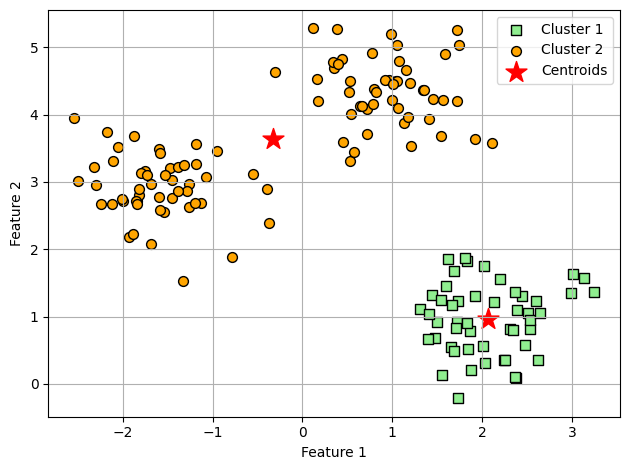

In [11]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            edgecolor='black',
            marker='s',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            edgecolor='black',
            marker='o',
            label='Cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.tight_layout()
# plt.savefig('images/11_05.png', dpi=300)
plt.show()

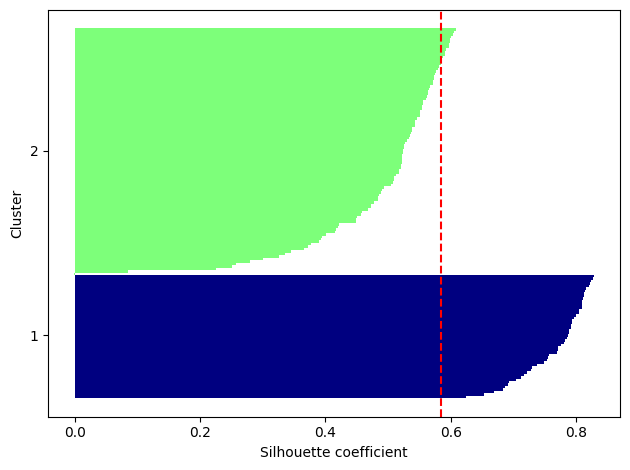

In [12]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('images/11_06.png', dpi=300)
plt.show()

# 계층적인 트리로 클러스터 조직화

## 상향식으로 클러스터 묶기

In [13]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch10/figures/10_07.png', width=400)

In [14]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## 거리 행렬에서 계층 군집 수행

In [15]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


함수 설명을 보면 `pdist` 함수에서 계산한 축약된 거리 행렬(상삼각행렬(upper triangular matrix))을 입력 속성으로 사용할 수 있습니다. 아니면 `linkage` 함수에 초기 데이터 배열을 전달하고 `metric='euclidean'` 지표를 매개변수로 사용할 수 있습니다. 앞서 `squareform` 함수로 만든 거리 행렬은 `linkage` 함수가 기대한 값과 다르기 때문에 사용해서는 안됩니다.

In [16]:
# 1. 잘못된 방식: squareform 거리 행렬

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

<ipython-input-16-9dd0eba25b7e>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_clusters = linkage(row_dist, method='complete', metric='euclidean')


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [17]:
# 2. 올바른 방식: 축약된 거리 행렬

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [18]:
# 3. 올바른 방식: 입력 샘플 행렬

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


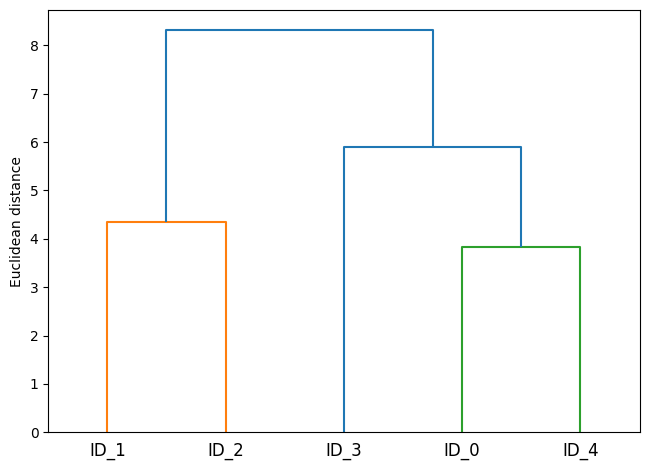

In [19]:
from scipy.cluster.hierarchy import dendrogram

# 검은색 덴드로그램 만들기 (1/2 부분만)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters,
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
# plt.savefig('images/11_11.png', dpi=300,
#            bbox_inches='tight')
plt.show()

## 히트맵에 덴드로그램 연결

<ipython-input-20-eb84f823cd67>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_xticklabels([''] + list(df_rowclust.columns))
<ipython-input-20-eb84f823cd67>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_yticklabels([''] + list(df_rowclust.index))


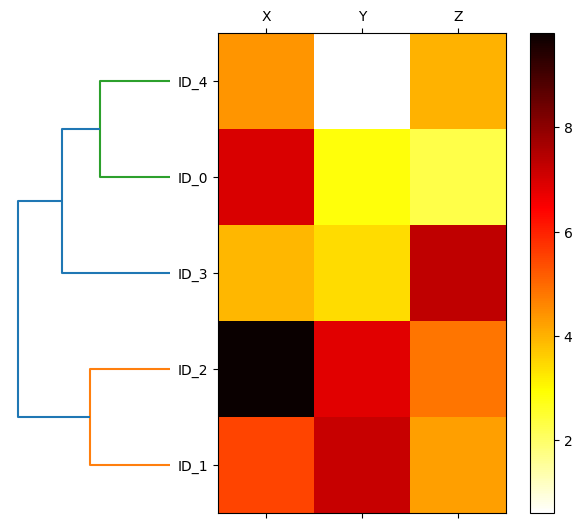

In [20]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# 노트: matplotlib < v1.5.1일 때는 use orientation='right'를 사용하세요
row_dendr = dendrogram(row_clusters, orientation='left')

# 군집에 맞게 데이터를 재정렬합니다.
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# 덴드로그램의 축을 제거합니다.
for i in axd.spines.values():
    i.set_visible(False)

# 히트맵을 출력합니다.
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-위치, y-위치, 너비, 높이
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('images/11_12.png', dpi=300)
plt.show()

## 사이킷런에서 병합 군집 적용

In [21]:
from sklearn.cluster import AgglomerativeClustering

# 사이킷런 1.2버전에서 `affinity` 매개변수가 deprecated되고
# 1.4버전에서 삭제되므로 대신 `metric`을 사용합니다.
ac = AgglomerativeClustering(n_clusters=3,
                             metric='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print(f'클러스터 레이블: {labels}')

클러스터 레이블: [1 0 0 2 1]


In [22]:
# 사이킷런 1.2버전에서 `affinity` 매개변수가 deprecated되고
# 1.4버전에서 삭제되므로 대신 `metric`을 사용합니다.
ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print(f'클러스터 레이블: {labels}')

클러스터 레이블: [0 1 1 0 0]


# DBSCAN을 사용하여 밀집도가 높은 지역 찾기

In [23]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch10/figures/10_13.png', width=500)

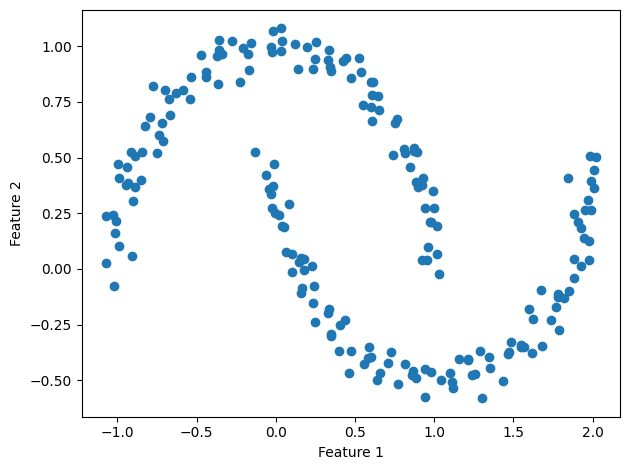

In [24]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
# plt.savefig('images/11_14.png', dpi=300)
plt.show()

K-평균과 계층 군집:

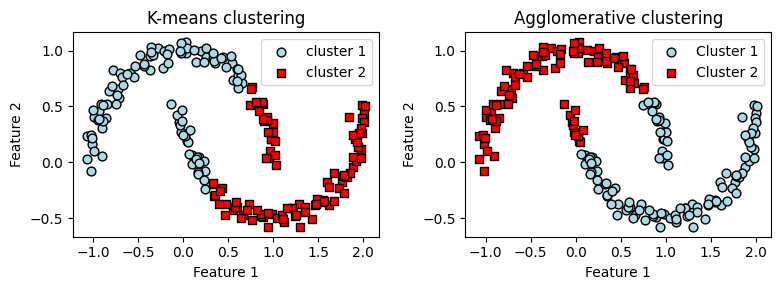

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, n_init=10, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.legend()

# 사이킷런 1.2버전에서 `affinity` 매개변수가 deprecated되고
# 1.4버전에서 삭제되므로 대신 `metric`을 사용합니다.
ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()

plt.tight_layout()
# plt.savefig('images/11_15.png', dpi=300)
plt.show()

DBSCAN:

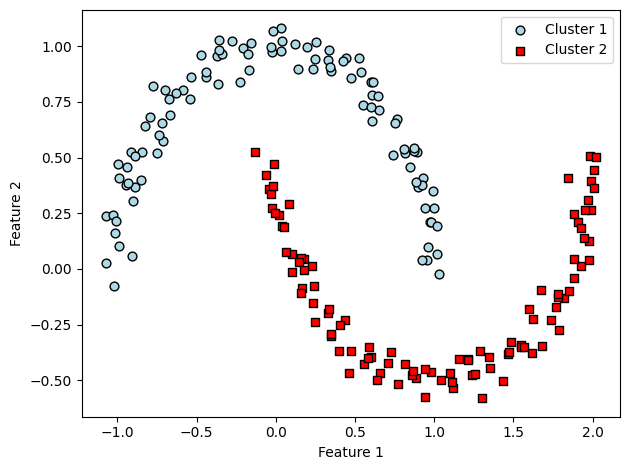

In [26]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black',
            label='Cluster 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
# plt.savefig('images/11_16.png', dpi=300)
plt.show()

# 요약